In [2]:
import pandas as pd
# import gzip
import numpy as np
# import json
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
df = pd.read_csv('Video_Games.csv')

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 497419 entries, 0 to 497418
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Unnamed: 0       497419 non-null  int64  
 1   overall          497419 non-null  float64
 2   verified         497419 non-null  bool   
 3   reviewTime       497419 non-null  object 
 4   reviewerID       497419 non-null  object 
 5   asin             497419 non-null  object 
 6   reviewerName     497209 non-null  object 
 7   reviewText       493758 non-null  object 
 8   summary          497305 non-null  object 
 9   unixReviewTime   497419 non-null  int64  
 10  vote             107784 non-null  object 
 11  style            289123 non-null  object 
 12  image            3600 non-null    object 
 13  Positive Rating  497419 non-null  int64  
dtypes: bool(1), float64(1), int64(3), object(9)
memory usage: 49.8+ MB


# Data preprocessing
1. Dropping empty rows in 2 column contain features

In [28]:
ratingonly = df.shape
df = df.dropna(axis='index' ,subset=['overall', 'reviewText'])
df.head()

,Unnamed: 0,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,Positive Rating
0,331389,5.0,True,"05 25, 2015",A1AEQBAT5NEP6T,B00FUC6T0S,NastyPoet,mix red dead redemption oblivion great graphic...,worth it,1432512000,NaN,NaN,NaN,1
1,491061,5.0,True,"06 6, 2017",A2NC6HBK3NM1GC,B00K5K4JQG,Oiharau,fun,Five Stars,1496707200,NaN,{'Edition:': ' Standard'},NaN,1
2,377211,5.0,True,"09 1, 2015",A2HZ44XXLCE9OM,B00N4ABT1C,Steven Pearce,like amiibos honest first thought waste time m...,Don't knock it until you try it,1441065600,NaN,"{'Color:': ' Link', 'Edition:': ' USA'}",NaN,1
3,398491,4.0,True,"12 29, 2015",AB5201IGTB1FX,B00WU6H78U,Kiko,code realize otome visual novel game takes pla...,Fun and cute game for otome and visual novel f...,1451347200,3,{'Format:': ' Video Game'},NaN,0
4,135809,3.0,False,"09 4, 2009",A12EG8H75DEYNP,B00163ROMW,Blitz Patel,really liked concept rpg sonic game like game ...,A decent game,1252022400,NaN,NaN,NaN,0


2. Current data distribution

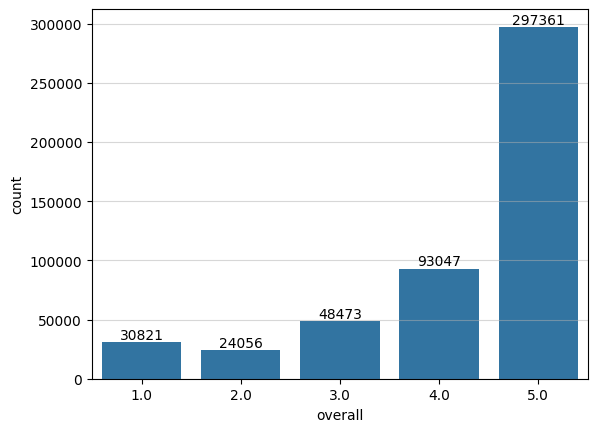

In [29]:
ax=sns.countplot(x='overall', data=df)
ax.bar_label(ax.containers[0])
plt.grid(visible=True,axis='y',alpha=0.5)
plt.show()

In [ ]:
"""Define a new column 'Positive Rating', which values containe 0 and 1 for positive and negative reviews"""
rating_threshold = 4 #review is postive if rating is >=4
df['Positive Rating'] = df['overall'].apply(lambda x: 1 if x>=rating_threshold else 0)
df['Positive Rating'].head(10)

In [ ]:
from nltk.corpus import stopwords
import re
from nltk.tokenize import word_tokenize, RegexpTokenizer

Function to normalize and clean data

In [ ]:
def clean_text(text):
    # lower text
    text = text.lower()
    # remove hyperlinks
    text = re.compile(r'^https?://', re.IGNORECASE).sub(r'', text)
    # remove non-letters
    text = re.sub("[^a-zA-Z]", " ", text)
    text = word_tokenize(text)
    # remove stopwords
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    # remove punctuation
    text = RegexpTokenizer(r'\w+').tokenize(text)
    text = " ".join(text)
    # remove words less than 3 letters
    text = re.sub(r'\b\w{1,2}\b', '', text)
    return text  

Resampling data to increase number of negative reviews records and at the same time reduce data for faster training

In [33]:
from sklearn.utils import resample

majority = df[df['Positive Rating']==1]
minority = df[df['Positive Rating']==0]
minority_upsampled = resample(minority, replace=True, n_samples=int(len(minority)*1.6), random_state=87)
majority_downsampled =  resample(majority, replace=True, n_samples=int(len(majority)/2.2), random_state=100)
resampled_df = pd.concat([majority_downsampled, minority_upsampled])

print(resampled_df.shape)
resampled_df['overall'].value_counts()
# resampled_df.to_csv('Video_Games_Resampled.csv')

(345238, 15)


overall
3.0    123992
1.0     78806
2.0     61778
5.0     61181
4.0     19481
Name: count, dtype: int64

In [54]:
df=pd.read_csv('Video_Games_Resampled.csv')
df.shape

(342818, 15)

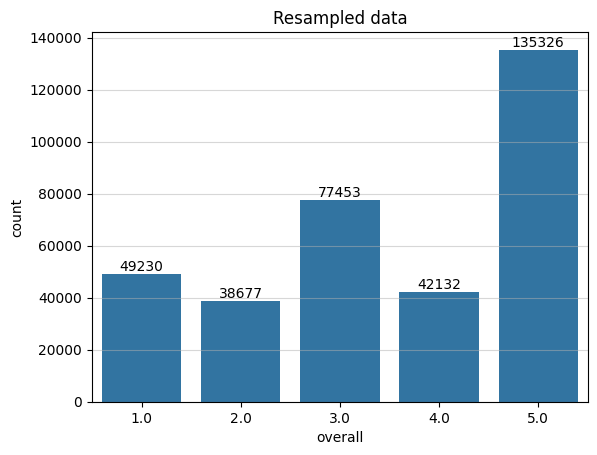

In [22]:
ax=sns.countplot(x='overall', data=df)
ax.bar_label(ax.containers[0])
plt.grid(visible=True,axis='y',alpha=0.5)
plt.title("Resampled data")
plt.show()

Split data into train and test set. `train_test_split` return a tuple of pd Series object where x contain review data and y contain label data

In [55]:
from sklearn.model_selection import train_test_split

trainx, testx, trainy, testy = train_test_split(df['reviewText'], df['Positive Rating'], test_size=0.23, random_state=42)
print(len(trainx))
print(len(testx))
train = pd.concat([trainx, trainy], axis =1)
test = pd.concat([testx, testy], axis=1)
# train.to_csv('train_data.csv', index=True)
# test.to_csv('test_data.csv',index=True)

263969
78849


In [22]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
# from sklearn.feature_extraction.text import TfidfVectorizer
# import torch.nn.functional as F
import time
from tqdm import tqdm

Ultility functions used to tokenize sentences

input = "I got an ice cream"

tokenize_output = ["I", "got", "an", "ice", "cream"]

In [10]:
import spacy
from torchtext.vocab import build_vocab_from_iterator
import torchtext.transforms as T
# spacy.cli.download("en_core_web_sm")##newline
eng = spacy.load("en_core_web_sm")
from torchtext.data.utils import get_tokenizer
tokenizer = get_tokenizer("basic_english")
def engTokenize(text):
    """
    Tokenize an English text and return a list of tokens
    """
    return [token.text for token in eng.tokenizer(text)]

def tokenize(data):
    for x in data:
        yield engTokenize(x)

Build vocabulary from the dataset. Basically tokenizing all the unique words from the whole data for later put into vectorizing

In [ ]:
vocab_train = build_vocab_from_iterator(
    tokenize(trainx),
    min_freq=2,
    specials= ['<pad>', '<sos>', '<eos>', '<unk>'],
    special_first=True
)
vocab_train.set_default_index(vocab_train['<unk>'])
vocab_test = build_vocab_from_iterator(
    tokenize(testx),
    min_freq=2,
    specials= ['<pad>', '<sos>', '<eos>', '<unk>'],
    special_first=True
)
vocab_test.set_default_index(vocab_test['<unk>'])


Building vocab take a long time so I pickle the variable as files for faster load later

In [7]:
import pickle
import os

if os.path.exists('vocab_train.pkl'):
    print('Load vocab train')
    with open('vocab_train.pkl', 'rb') as vocab_train_file:
        vocab_train = pickle.load(vocab_train_file)
# else:
#     # Save the trained vocab_train
#     print('Save vocab train')
#     with open('vocab_train.pkl', 'wb') as vocab_train_file:
#         pickle.dump(vocab_train, vocab_train_file)

if os.path.exists('vocab_test.pkl'):
    print('Load vocab test')
    # Load vocab_test from the pickle file
    with open('vocab_test.pkl', 'rb') as vocab_test_file:
        vocab_test = pickle.load(vocab_test_file)
# else:
#     print('Save vocab test')
#     # Save the trained vocab_test
#     with open('vocab_test.pkl', 'wb') as vocab_test_file:
#         pickle.dump(vocab_test, vocab_test_file)


print(vocab_train.get_itos()[:45])

Load vocab train
Load vocab test
['<pad>', '<sos>', '<eos>', '<unk>', 'game', ' ', 'like', 'one', 'games', 'get', 'play', 'good', 'really', 'time', 'great', 'fun', 'would', 'much', 'even', 'first', 'also', 'well', 'graphics', 'story', 'new', 'playing', 'way', 'better', 'still', 'make', 'use', 'played', 'many', 'could', 'lot', 'want', 'back', 'little', 'pretty', 'buy', 'gameplay', 'bad', 'people', 'best', 'got']


In [24]:
vocabsize = len(vocab_train)
print(vocabsize)

77587


In [25]:
# Define the dimensions
input_dim = vocabsize # The dimension of your input data (e.g., vocabulary size)
hidden_dim = 256  # Size of the hidden layer
embedding_dim =  128
output_dim = 1  # Two classes: positive and negative
learning_rate = 0.001
epochs = 100
batch_size = 128

Use device GPU for training

In [26]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU available. Using GPU.")
else:
    device = torch.device("cpu")
    print("GPU not available. Using CPU.")
print(device)

GPU available. Using GPU.
cuda


The LSTM model, with the following structure:

- Word Embedding Layer
- LSTM layer
- 3 fully connected layer
- Dropout layer

In [27]:
# Define the classification model
class SentimentClassifier(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super(SentimentClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.LSTM(input_size= embedding_dim,
                                hidden_size=hidden_dim)        
        
        self.fc1 = nn.Linear(hidden_dim, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc3 = nn.Linear(128, 32)
        self.fc4 = nn.Linear(32,output_dim)
        # self.sm = nn.LogSoftmax(dim=1)

    def forward(self, text, length):
        """text dim: padded sequence object with max length = length"""
        
        embedded = self.embedding(text)
        """embedded dimension: [length, batch size, embedding dim]"""
        # Pack the sequences for efficient processing
        packed_data = pack_padded_sequence(embedded, length.sum(1), batch_first=True, enforce_sorted=False)
        output, (hidden, cell) = self.rnn(packed_data)
        """# output dim: [length, batch size, hidden dim]"""
        """# hidden dimension: [1, batch size, hidden dim]"""
        # unpacked_output, unpacked_length = pad_packed_sequence(output,batch_first=True)
        # unpacked_output.squeeze_(1)
        o = self.fc1(hidden.squeeze(0)) 
        """hidden dim: [batch size, hidden dim]"""
        o = self.dropout(o)
        o = self.fc3(o)
        o = self.dropout(o)
        o = self.fc4(o)
        # o = self.sm(o)
        return o

Dataset class (for pytorch)

In [28]:
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        """This function is called everytime we iterate through the dataloader"""
        # sample = {'data': self.data[idx], 'label': self.labels[idx]}
        return self.data.iloc[idx], self.labels[idx]



In [29]:
y_train = trainy.values
y_test = testy.values

print(y_train)

[1 1 0 ... 1 1 1]


Function to transform dataset into vectors given the vocabulary

In [30]:
def getTransform(vocab):
    """
    Create transforms based on given vocabulary. The returned transform is applied to sequence
    of tokens.
    """
    text_tranform = T.Sequential(
        ## converts the sentences to indices based on given vocabulary
        T.VocabTransform(vocab=vocab),
        ## Add <sos> at beginning of each sentence. 1 because the index for <sos> in vocabulary is
        # 1 as seen in previous section
        T.AddToken(1, begin=True),
        ## Add <eos> at beginning of each sentence. 2 because the index for <eos> in vocabulary is
        # 2 as seen in previous section
        T.AddToken(2, begin=False)
    )
    return text_tranform
def applyTransform(text):
    """
    Apply transforms to sequence of tokens in a sequence pair
    """

    return getTransform(vocab_train)(engTokenize(text))

In [14]:
x_train = trainx.apply(applyTransform)
x_test = testx.apply(applyTransform)

In [31]:
if os.path.exists('x_train.pkl'):
    print('Load x_train vectors')
    # Load vocab_test from the pickle file
    with open('x_train.pkl', 'rb') as x_train_file:
        x_train = pickle.load(x_train_file)
# else:
#     print('Save x_train vectors')
#     # Save the trained vocab_test
#     with open('x_train.pkl', 'wb') as x_train_file:
#         pickle.dump(x_train, x_train_file)

if os.path.exists('x_test.pkl'):
    print('Load x_test vectors')
    # Load vocab_test from the pickle file
    with open('x_test.pkl', 'rb') as x_test_file:
        x_test = pickle.load(x_test_file)
# else:
#     print('Save x_test vectors')
#     # Save the trained vocab_test
#     with open('x_test.pkl', 'wb') as x_test_file:
#         pickle.dump(x_test, x_test_file)

Load x_train vectors
Load x_test vectors


Data with different length vectors cannot be passed into an LSTM layer directly. To enable processing of variable-length sequences, padding is applied to ensure all vectors within a batch have the same length. For instance:

Original data:
```
data = [
    torch.tensor([16]),
    torch.tensor([204, 185, 65, 345]), 
    torch.tensor([204, 987]),
    torch.tensor([85, 4, 23])
]
```

Padded batch:
```
tensor([
    [ 16,   0,   0,   0], 
    [204, 185,  65, 345], 
    [204, 987,   0,   0], 
    [ 85,   4,  23,   0]
])
```

In this example, the vectors have been padded with zeros to match the length of the longest sequence within the batch, enabling their use in sequence-based models like LSTMs.

In [32]:
def custom_collate_fn(batch):
    data, labels = zip(*batch)

    # Sort sequences by length (from longest to shortest)
    sorted_data, sorted_labels = zip(*sorted(zip(data, labels), key=lambda x: len(x[0]), reverse=True))

    # Pad sequences to the length of the longest sequence
    padded_data = pad_sequence([torch.tensor(seq) for seq in sorted_data], batch_first=True)
    padded_labels = torch.tensor(sorted_labels, dtype=torch.float64)

    # Create a mask for the padded elements
    mask = (padded_data != 0).float()

    return padded_data.to(device), mask, padded_labels.to(device)

Intialize dataset and dataloader

In [56]:
torch.manual_seed(12)
trainset = CustomDataset(x_train, y_train)
testset = CustomDataset(x_test, y_test)

# trainset = CustomDataset(vocab_train, y_train_onehot)
# testset = CustomDataset(vocab_test, y_test)

# Create a DataLoader for your dataset
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)


Model, Loss function and optimizer initilaization

In [34]:
# Instantiate the classifier
model = SentimentClassifier(input_dim, embedding_dim, hidden_dim, output_dim).to(device)
# Define the loss function (cross-entropy) and the optimizer (Adam)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
for x,y,z in test_loader:
    print(x)
    print('AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA')
    print(y)
    print('AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA')
    print(z.unsqueeze(1))
    print('AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA')
    # seq_unpacked, lens_unpacked = pad_packed_sequence(x, batch_first=True)
    # print(seq_unpacked)
    break

Try predicting without training

In [55]:
torch.manual_seed(76)
total_acc, total_count = 0,0
for x,y,z in test_loader:
    z = z.unsqueeze(1)
    predictions = model(x,y)
    # print(predictions)
    # print(z)
    # loss = criterion(predictions,z)
    # loss.backward()
    # print(loss.item())
    
    result = (predictions>0).float()
    result = result[torch.all(result==z, dim=1)]
    # print(result)
    total_acc += len(result)
    total_count += len(z)
    print(f"{total_acc/total_count*100}%")
    break

60.15625%


Training loop and Testing loop

In [38]:
def trainloop(trainloader):
    epoch_train_loss = 0.0
    model.train()
    with tqdm(trainloader, unit="batch", desc='Training: ') as tbatch:
        for data, mask, labels in tbatch:
            labels = labels.unsqueeze(1)
            optimizer.zero_grad()
            output = model(data, mask)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss
            tbatch.set_postfix(loss="{:.6f}".format(loss))
    return epoch_train_loss/len(trainloader)

def evaluateloop(testloader):
    model.eval()
    total_acc, total_count = 0, 0
    with tqdm(testloader, unit="batch", desc='Evaluating: ') as ttest:
        with torch.no_grad():
            for data, mask, labels in ttest:
                labels = labels.unsqueeze(1)
                predictions = model(data, mask)
                result = (predictions>0).float()
                result = result[torch.all(result==labels, dim=1)]
                total_acc += len(result)
                total_count += len(labels)
                ttest.set_postfix({'accuracy': total_acc / total_count})
    accuracy = total_acc / total_count
    return accuracy

Function to save model in case of interuption and resume training from file

In [37]:
def checkpoint(model, optimizer, loss, epoch, filename):
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
        }, filename)
def resume(filename):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    return loss

In [47]:
start_time = time.time()
torch.manual_seed(0)
last_lost = 0.0 #the lost of the last epoch
patience = 3 
trigger_times = 0 #counter for early stop
stop = False
start_epoch=0
curr_epoch = 0
delta = 0.0002
counter = 0
try:
    with open('loss_values.pkl', 'rb') as f_loss, open('accuracy_values.pkl', 'rb') as f_accuracy:
        loss_array = pickle.load(f_loss)
        accuracy_array = pickle.load(f_accuracy)
except FileNotFoundError:
    # If files don't exist, initialize empty arrays
    loss_array = [] #used for graphing loss changes throughout training
    accuracy_array = [] 


if start_epoch>0:
    print("Found existing checkpoint, continue training")
    last_lost = resume(f'Model_at_epoch_{start_epoch}.pth')

try:
    for epoch in range(start_epoch, epochs):
        curr_epoch = epoch
        #Train
        train_loss = trainloop(train_loader)

        #Test
        accuracy = evaluateloop(test_loader)
        accuracy_array+=[accuracy]
        loss_array+=[train_loss]

        if counter%5==0:
            checkpoint(model, optimizer, loss_array[-1], curr_epoch, f'Model_at_epoch_{curr_epoch}.pth')
            with open('loss_values.pkl', 'wb') as f_loss, open('accuracy_values.pkl', 'wb') as f_accuracy:
                pickle.dump(loss_array, f_loss)
                pickle.dump(accuracy_array, f_accuracy)

        counter+=1
        # Print statistics at the end of each epoch
        print(f'Epoch [{epoch+1}/{epochs}] | Test Accuracy: {accuracy:.2%} | Current Loss: {train_loss: .6f}\n')
        #Early stopping check
        if abs(train_loss - last_lost)<=delta:
            trigger_times+=1
        elif abs(train_loss - last_lost)>delta:
            trigger_times=0
        if trigger_times>patience:
            stop = True
        last_lost=train_loss
        if stop == True:
            break
except KeyboardInterrupt:
    print("Training interrupted. Saving current model checkpoint.")
    checkpoint(model, optimizer, loss_array[-1], curr_epoch, f'Model_at_epoch_{curr_epoch}.pth')
    with open('loss_values.pkl', 'wb') as f_loss, open('accuracy_values.pkl', 'wb') as f_accuracy:
        pickle.dump(loss_array, f_loss)
        pickle.dump(accuracy_array, f_accuracy)

# Print total training time
print("Total training time: {:.2f} seconds".format(time.time() - start_time))
#Save model
checkpoint(model, optimizer, loss_array[-1], curr_epoch, f'Model_at_epoch_{curr_epoch}.pth')
with open('loss_values.pkl', 'wb') as f_loss, open('accuracy_values.pkl', 'wb') as f_accuracy:
    pickle.dump(loss_array, f_loss)
    pickle.dump(accuracy_array, f_accuracy)


Training:   0%|          | 0/2063 [00:00<?, ?batch/s]

Evaluating: 100%|██████████| 617/617 [00:40<00:00, 15.06batch/s, accuracy=0.856]


Epoch [1/100] | Test Accuracy: 85.62% | Current Loss:  0.332058



Evaluating: 100%|██████████| 617/617 [00:37<00:00, 16.54batch/s, accuracy=0.877]


Epoch [2/100] | Test Accuracy: 87.66% | Current Loss:  0.268223



Evaluating: 100%|██████████| 617/617 [00:35<00:00, 17.58batch/s, accuracy=0.896]


Epoch [3/100] | Test Accuracy: 89.60% | Current Loss:  0.200116



Evaluating: 100%|██████████| 617/617 [00:35<00:00, 17.22batch/s, accuracy=0.908]


Epoch [4/100] | Test Accuracy: 90.77% | Current Loss:  0.137502



Evaluating: 100%|██████████| 617/617 [00:35<00:00, 17.28batch/s, accuracy=0.907]


Epoch [5/100] | Test Accuracy: 90.72% | Current Loss:  0.093940



Evaluating: 100%|██████████| 617/617 [00:35<00:00, 17.31batch/s, accuracy=0.91] 


Epoch [6/100] | Test Accuracy: 90.98% | Current Loss:  0.075351



Evaluating: 100%|██████████| 617/617 [00:35<00:00, 17.25batch/s, accuracy=0.91] 


Epoch [7/100] | Test Accuracy: 91.05% | Current Loss:  0.061622



Evaluating: 100%|██████████| 617/617 [00:36<00:00, 17.00batch/s, accuracy=0.912]


Epoch [8/100] | Test Accuracy: 91.21% | Current Loss:  0.057610



Evaluating: 100%|██████████| 617/617 [00:36<00:00, 17.04batch/s, accuracy=0.914]


Epoch [9/100] | Test Accuracy: 91.36% | Current Loss:  0.050050



Evaluating: 100%|██████████| 617/617 [00:37<00:00, 16.47batch/s, accuracy=0.914]


Epoch [10/100] | Test Accuracy: 91.42% | Current Loss:  0.050314



Evaluating: 100%|██████████| 617/617 [00:36<00:00, 17.10batch/s, accuracy=0.916]


Epoch [11/100] | Test Accuracy: 91.58% | Current Loss:  0.045930



Evaluating: 100%|██████████| 617/617 [00:39<00:00, 15.66batch/s, accuracy=0.912]


Epoch [12/100] | Test Accuracy: 91.21% | Current Loss:  0.043936



Evaluating: 100%|██████████| 617/617 [00:37<00:00, 16.37batch/s, accuracy=0.913]


Epoch [13/100] | Test Accuracy: 91.33% | Current Loss:  0.046479



Evaluating: 100%|██████████| 617/617 [00:38<00:00, 16.09batch/s, accuracy=0.912]


Epoch [14/100] | Test Accuracy: 91.22% | Current Loss:  0.043265



Evaluating: 100%|██████████| 617/617 [00:40<00:00, 15.33batch/s, accuracy=0.915]


Epoch [15/100] | Test Accuracy: 91.46% | Current Loss:  0.041918



Evaluating: 100%|██████████| 617/617 [00:38<00:00, 15.85batch/s, accuracy=0.913]


Epoch [16/100] | Test Accuracy: 91.29% | Current Loss:  0.039851



Evaluating: 100%|██████████| 617/617 [00:46<00:00, 13.35batch/s, accuracy=0.916]


Epoch [17/100] | Test Accuracy: 91.59% | Current Loss:  0.040254



Training:  61%|██████    | 1254/2063 [03:16<02:07,  6.37batch/s, loss=0.045123]


Training interrupted. Saving current model checkpoint.
Total training time: 5884.01 seconds


Create some sentences for testing

In [35]:
test_sentence = 'i love this game'
test_sentence2 = 'trash game'
test_sentence3 = 'greate game i like it'
test_sentence4 = 'i regret buying it'
data = [test_sentence, test_sentence2, test_sentence3, test_sentence4]
result = [1,0,1,0]
column_names = ['text', 'positive']
df = pd.DataFrame(list(zip(data, result)), columns=column_names)

text = df['text']
label = df['positive']
evaluate = CustomDataset(text.apply(applyTransform),label.values)
evaloader = DataLoader(evaluate,batch_size=1, collate_fn=custom_collate_fn)

In [40]:
print(resume("model_colab\Model_at_epoch_33.pth"))

for batch, text in zip(evaloader,data):
    x,y,z= batch
    predictions = model(x,y)
#     print(predictions)
    result = (predictions>0).float()
    result = (result==z)
    if result == True:
        print(f'Prediction result: {text} - Correct')
    else:
        print(f'Prediction result: {text} - Incorrect')

0.030076907514478345
Prediction result: i love this game - Correct
Prediction result: trash game - Correct
Prediction result: greate game i like it - Correct
Prediction result: i regret buying it - Incorrect


Loss and Accuracy graph

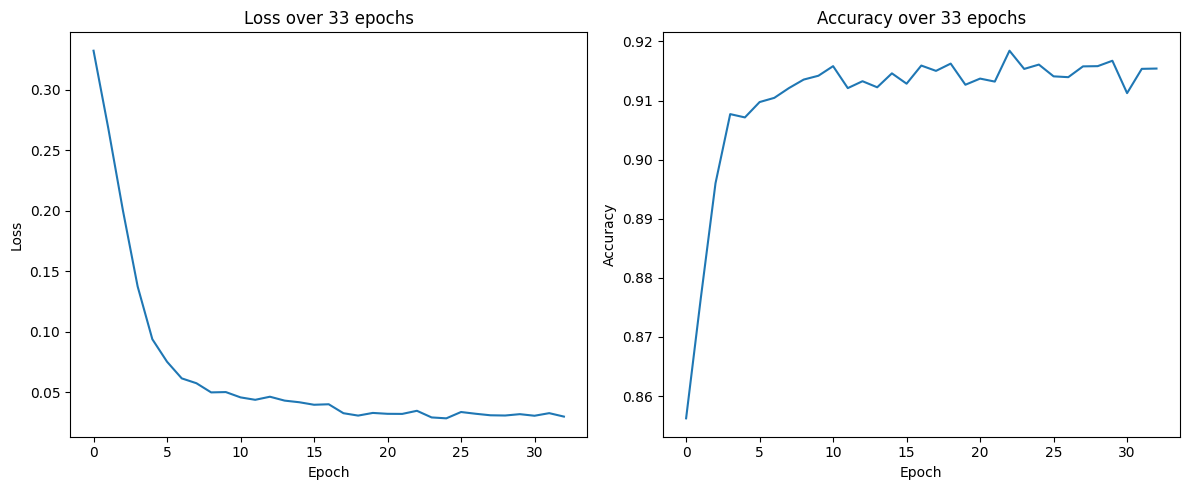

In [19]:
with open('model_colab/accuracy_values.pkl', 'rb') as acc:
    acc_array = pickle.load(acc)
with open('model_colab/loss_values.pkl', 'rb') as loss:
    loss_arrray = pickle.load(loss)

epoch = range(len(loss_arrray))

for i, x in enumerate(loss_arrray):
    if type(x) is float:
        continue
    else: loss_arrray[i] = x.item()
fig, ax = plt.subplots(1,2, figsize=(12,5)) 

ax[0].plot(epoch, loss_arrray)
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Loss over 33 epochs')

ax[1].plot(epoch, acc_array)
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Accuracy over 33 epochs')
plt.tight_layout()
plt.show()

In [61]:
from sklearn.metrics import confusion_matrix
model.eval()

# Collect predictions and true labels
prediction_list = []
true_labels = []

with torch.no_grad():
    for x,y,z in test_loader:
        z = z.unsqueeze(1)
        predictions = model(x,y)
        result = (predictions>0).float()
        # print(result)
        prediction_list.extend(result.squeeze(1).cpu().numpy())
        true_labels.extend(z.squeeze(1).cpu().numpy())
        # break
print(len(prediction_list))
print(len(true_labels))

78849
78849


Classification report: 
               precision    recall  f1-score   support

         0.0       0.90      0.93      0.91     37945
         1.0       0.93      0.91      0.92     40904

    accuracy                           0.92     78849
   macro avg       0.92      0.92      0.92     78849
weighted avg       0.92      0.92      0.92     78849



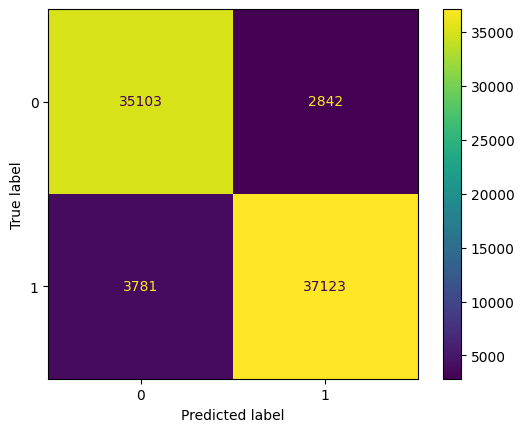

In [74]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report


conf_matrix = confusion_matrix(true_labels, prediction_list)
print("Classification report: \n", classification_report(true_labels, prediction_list))

# Plot confusion matrix

ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot()